In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.data_processing import butterfly1_pts, butterfly2_pts, sample_ellipse
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE, DampedBrownianSDE
from sdebridge.utils import eval_score

import matplotlib.pyplot as plt


2024-01-23 17:24:07.961795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 17:24:07.961827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 17:24:07.962911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 17:24:09.351943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [3]:
complex_to_real = lambda z: jnp.concatenate([z.real, z.imag], axis=0)
real_to_complex = lambda x: x[:len(x)//2] + 1j * x[len(x)//2:]

### Butterflies

(2, 120)
(2, 120)


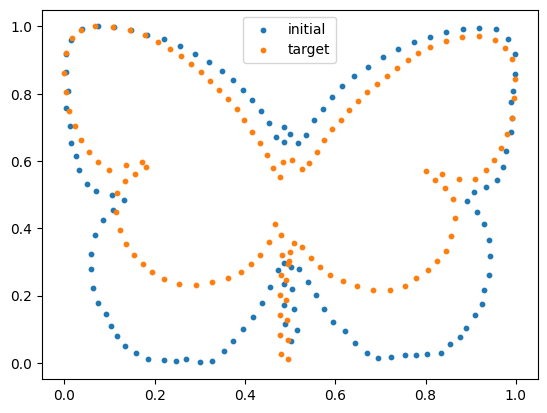

In [4]:
init_s = jnp.array(butterfly1_pts())[:, ::1861][:, ::1]
term_s = jnp.array(butterfly2_pts())[:, ::475][:, ::1]
print(init_s.shape)
print(term_s.shape)
plt.scatter(init_s[0], init_s[1], s=10, label='initial')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()

X shape: 
 (2, 120)
X coefficients (complex) shape: 
 (2, 24)
X (reconstructed) shape: 
 (2, 120)
XT (real represented) shape: 
 (2, 48)


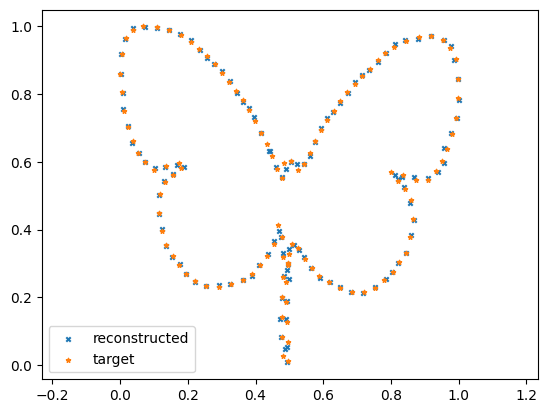

In [8]:
num_truncation = 24
num_samples = init_s.shape[-1]
X0 = jnp.zeros((4*num_truncation, ))

displacement = term_s - init_s
print("X shape: \n", displacement.shape)
XT_complex = jnp.fft.rfft2(displacement, norm='backward')[..., :num_truncation]
print("X coefficients (complex) shape: \n", XT_complex.shape)
displacement_recon = jnp.fft.irfft2(XT_complex, norm='backward', s=displacement.shape)
print("X (reconstructed) shape: \n", displacement_recon.shape)

XT = vmap(complex_to_real)(XT_complex)
print("XT (real represented) shape: \n", XT.shape)

term_s_recon = init_s + displacement_recon
with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(term_s_recon[0], term_s_recon[1], s=10, marker='x', label='reconstructed')
    plt.scatter(term_s[0], term_s[1], s=10, marker='*', label='target')
    plt.axis('equal')
    plt.legend()

In [9]:
sde_config = ConfigDict()
sde_config.dim = 4*num_truncation
sde_config.N = 50
sde_config.T = 1.0
sde_config.alpha = 1.0
sde = BrownianSDE(sde_config)
bridge = DiffusionBridge(sde)
print(sde_config)

N: 50
T: 1.0
alpha: 1.0
dim: 96



In [10]:
setup_params = {
    "network": {
        "output_dim": sde.dim,
        "time_embedding_dim": 96,
        "encoding_dim": 24,
        "act_fn": "silu",
        "encoder_layer_dims": [192, 96, 48],
        "decoder_layer_dims": [48, 96, 192],
        "batchnorm": True,
        "dropout_prob": 0.0,
    },
    "training": {
        "network_type": "UNet",
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0,
    setup_params=setup_params,
)

+------------------------------------------------+------------+--------+-----------+--------+
| Name                                           | Shape      | Size   | Mean      | Std    |
+------------------------------------------------+------------+--------+-----------+--------+
| Dense_0/bias                                   | (96,)      | 96     | 0.0       | 0.0    |
| Dense_0/kernel                                 | (96, 96)   | 9,216  | -0.00168  | 0.102  |
| Dense_1/bias                                   | (24,)      | 24     | 0.0       | 0.0    |
| Dense_1/kernel                                 | (48, 24)   | 1,152  | 0.00243   | 0.168  |
| Dense_2/bias                                   | (96,)      | 96     | 0.0       | 0.0    |
| Dense_2/kernel                                 | (192, 96)  | 18,432 | -0.000471 | 0.0832 |
| Downsample_0/BatchNorm_0/bias                  | (192,)     | 192    | 0.0       | 0.0    |
| Downsample_0/BatchNorm_0/scale                 | (192,)   

Training: 100%|██████████| 100/100 [44:47<00:00, 26.88s/epoch, Epoch=100, loss=42.7588]


In [11]:
score_p = partial(
    lambda val, time, score_p_state: eval_score(
        state=score_p_state,
        val=val,
        time=time,
    ),
    score_p_state=score_p_state
)
backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0,
    terminal_val=XT.flatten(),
    score_p=score_p,
    num_batches=4,
)

# backward_brownian_bridge = bridge.simulate_backward_bridge(
#     initial_val=X0,
#     terminal_val=XT.flatten(),
#     score_p=lambda val, time: -(val - X0) / (time * sde.alpha**2 + 1e-9), 
#     num_batches=4,
# )

(4, 50, 2, 48)
(4, 50, 2, 24)
(4, 50, 2, 120)


/home/gefan/tmp/ipykernel_230555/1146208732.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))


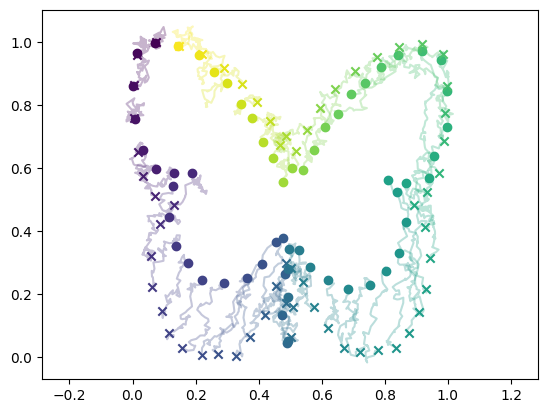

In [12]:
Xs = backward_brownian_bridge["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 50, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(partial(jnp.fft.irfft2, norm='backward', s=init_s.shape)))(coeffs)
print(displacements.shape)

n = 1
with jax.default_device(jax.devices('cpu')[0]):
    ss = displacements + init_s[None, None, :, :]
    colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))
    for i in jnp.arange(num_samples, step=2):
        plt.scatter(ss[n, 0, 0, i], ss[n, 0, 1, i], marker='o', color=colors[i])
        plt.plot(ss[n, :, 0, i], ss[n, :, 1, i], alpha=0.3, color=colors[i])
        plt.scatter(ss[n, -1, 0, i], ss[n, -1, 1, i], marker='x', color=colors[i])
    plt.axis('equal')

In [13]:
setup_params = {
    "network": {
        "output_dim": sde.dim,
        "time_embedding_dim": 96,
        "encoding_dim": 24,
        "act_fn": "silu",
        "encoder_layer_dims": [192, 96, 48],
        "decoder_layer_dims": [48, 96, 192],
        "batchnorm": True,
        "dropout_prob": 0.0,
    },
    "training": {
        "network_type": "UNet",
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_star_state = bridge.learn_p_star_score(
    initial_val=X0,
    terminal_val=XT.flatten(),
    score_p=score_p,
    setup_params=setup_params,
)

+------------------------------------------------+------------+--------+-----------+--------+
| Name                                           | Shape      | Size   | Mean      | Std    |
+------------------------------------------------+------------+--------+-----------+--------+
| Dense_0/bias                                   | (96,)      | 96     | 0.0       | 0.0    |
| Dense_0/kernel                                 | (96, 96)   | 9,216  | -0.00168  | 0.102  |
| Dense_1/bias                                   | (24,)      | 24     | 0.0       | 0.0    |
| Dense_1/kernel                                 | (48, 24)   | 1,152  | 0.00243   | 0.168  |
| Dense_2/bias                                   | (96,)      | 96     | 0.0       | 0.0    |
| Dense_2/kernel                                 | (192, 96)  | 18,432 | -0.000471 | 0.0832 |
| Downsample_0/BatchNorm_0/bias                  | (192,)     | 192    | 0.0       | 0.0    |
| Downsample_0/BatchNorm_0/scale                 | (192,)   

Training: 100%|██████████| 100/100 [38:48<00:00, 23.28s/epoch, Epoch=100, loss=39.4203]


In [14]:
score_h = partial(
    lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) \
                                                         - eval_score(state=score_p_state, val=val, time=time), 
                                                         score_p_state=score_p_state, 
                                                         score_p_star_state=score_p_star_state)
# score_h = partial(
#     lambda val, time, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) \
#                                           + (val - X0) / (time * sde.alpha**2 + 1e-9),
#                                           score_p_star_state=score_p_star_state)
# score_h = lambda val, time: -(val - XT.flatten()) / ((sde.T - time)*sde.alpha**2 + 1e-8)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT.flatten(),
                                                         score_h=score_h,
                                                         num_batches=4)

Xs = forward_brownian_bridge["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 50, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(partial(jnp.fft.irfft2, norm='backward', s=init_s.shape)))(coeffs)
print(displacements.shape)

ss = displacements + init_s[None, None, :, :]
colormaps = plt.cm.get_cmap('viridis', num_samples)
colors = colormaps(jnp.linspace(0, 1, num_samples))

(4, 50, 2, 48)
(4, 50, 2, 24)
(4, 50, 2, 120)


/home/gefan/tmp/ipykernel_230555/1743295243.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormaps = plt.cm.get_cmap('viridis', num_samples)


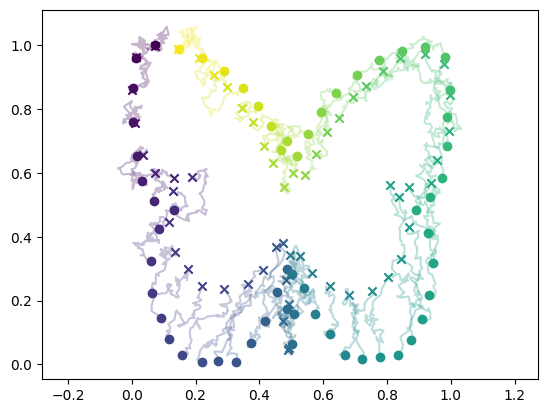

In [15]:
n = 1
with jax.default_device(jax.devices('cpu')[0]):
    for i in jnp.arange(num_samples, step=2):
        plt.scatter(ss[n, 0, 0, i], ss[n, 0, 1, i], marker='o', color=colors[i])
        plt.plot(ss[n, :, 0, i], ss[n, :, 1, i], alpha=0.3, color=colors[i])
        plt.scatter(ss[n, -1, 0, i], ss[n, -1, 1, i], marker='x', color=colors[i])
    plt.axis('equal')

## Circles

init_s shape:  (2, 256)
term_s shape:  (2, 256)


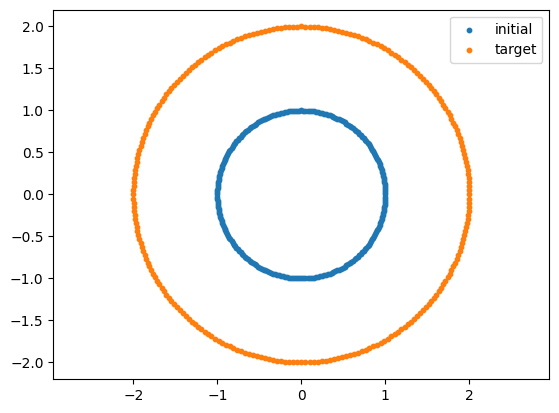

In [4]:
init_s = sample_ellipse(num_points=256, scale=1.0)
term_s = sample_ellipse(num_points=256, scale=2.0)
print("init_s shape: ", init_s.shape)
print("term_s shape: ", term_s.shape)
plt.scatter(init_s[0], init_s[1], s=10, label='initial')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()
plt.axis('equal')
plt.show()

X shape: 
 (2, 256)
X coefficients (complex) shape: 
 (2, 8)
X (reconstructed) shape: 
 (2, 256)
XT (real represented) shape: 
 (2, 16)


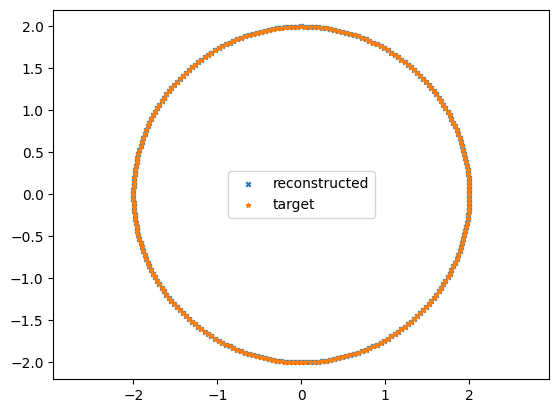

In [103]:
num_truncation = 8
num_samples = init_s.shape[-1]
X0 = jnp.zeros((4*num_truncation, ))

displacement = term_s - init_s
print("X shape: \n", displacement.shape)
XT_complex = jnp.fft.rfft2(displacement, norm='backward')[..., :num_truncation]
print("X coefficients (complex) shape: \n", XT_complex.shape)
displacement_recon = jnp.fft.irfft2(XT_complex, norm='backward', s=displacement.shape)
print("X (reconstructed) shape: \n", displacement_recon.shape)

XT = vmap(complex_to_real)(XT_complex)
print("XT (real represented) shape: \n", XT.shape)

term_s_recon = init_s + displacement_recon
with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(term_s_recon[0], term_s_recon[1], s=10, marker='x', label='reconstructed')
    plt.scatter(term_s[0], term_s[1], s=10, marker='*', label='target')
    plt.axis('equal')
    plt.legend()

In [104]:
sde_config = ConfigDict()
sde_config.dim = 4*num_truncation
sde_config.N = 50
sde_config.T = 1.0
sde_config.alpha = 10.0
# sde = DampedBrownianSDE(sde_config)
sde = BrownianSDE(sde_config)
bridge = DiffusionBridge(sde)
print(sde.config)

N: 50
T: 1.0
alpha: 10.0
dim: 32



In [105]:
setup_params = {
    "network": {
        "output_dim": sde.dim,
        "time_embedding_dim": 64,
        "encoding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [256, 128, 64],
        "decoder_layer_dims": [64, 128, 256],
        "batchnorm": False,
        "dropout_prob": 0.0,
    },
    "training": {
        "network_type": "UNet",
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0,
    setup_params=setup_params,
)

+------------------------------------------------+------------+---------+-----------+--------+
| Name                                           | Shape      | Size    | Mean      | Std    |
+------------------------------------------------+------------+---------+-----------+--------+
| Dense_0/bias                                   | (64,)      | 64      | 0.0       | 0.0    |
| Dense_0/kernel                                 | (32, 64)   | 2,048   | -0.00206  | 0.143  |
| Dense_1/bias                                   | (32,)      | 32      | 0.0       | 0.0    |
| Dense_1/kernel                                 | (64, 32)   | 2,048   | -0.0041   | 0.144  |
| Dense_2/bias                                   | (32,)      | 32      | 0.0       | 0.0    |
| Dense_2/kernel                                 | (256, 32)  | 8,192   | 0.000729  | 0.0843 |
| Downsample_0/Dense_0/bias                      | (64,)      | 64      | 0.0       | 0.0    |
| Downsample_0/Dense_0/kernel                    |

Training: 100%|██████████| 100/100 [02:10<00:00,  1.31s/epoch, Epoch=100, loss=14.2527]


In [114]:
score_p = partial(
    lambda val, time, score_p_state: eval_score(
        state=score_p_state,
        val=val,
        time=time,
    ),
    score_p_state=score_p_state
)
backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0,
    terminal_val=XT.flatten(),
    score_p=score_p,
    num_batches=4,
)

# backward_brownian_bridge = bridge.simulate_backward_bridge(
#     initial_val=X0,
#     terminal_val=XT.flatten(),
#     score_p=lambda val, time: -(val - X0) / (time * sde.alpha**2 + 1e-9), 
#     num_batches=4,
# )

In [115]:
Xs = backward_brownian_bridge["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 50, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(partial(jnp.fft.irfft2, norm='backward', s=init_s.shape)))(coeffs)
print(displacements.shape)

(4, 50, 2, 16)
(4, 50, 2, 8)
(4, 50, 2, 256)


/home/gefan/tmp/ipykernel_183070/657892719.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))


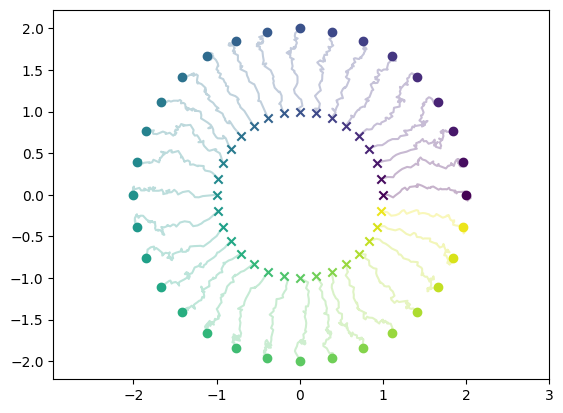

In [116]:
n = 1
with jax.default_device(jax.devices('cpu')[0]):
    ss = displacements + init_s[None, None, :, :]
    colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))
    for i in jnp.arange(num_samples, step=8):
        plt.scatter(ss[n, 0, 0, i], ss[n, 0, 1, i], marker='o', color=colors[i])
        plt.plot(ss[n, :, 0, i], ss[n, :, 1, i], alpha=0.3, color=colors[i])
        plt.scatter(ss[n, -1, 0, i], ss[n, -1, 1, i], marker='x', color=colors[i])
    plt.axis('equal')

In [117]:
setup_params = {
    "network": {
        "output_dim": sde.dim,
        "time_embedding_dim": 64,
        "encoding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [256, 128, 64],
        "decoder_layer_dims": [64, 128, 256],
        "batchnorm": False,
        "dropout_prob": 0.0,
    },
    "training": {
        "network_type": "UNet",
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_star_state = bridge.learn_p_star_score(
    initial_val=X0,
    terminal_val=XT.flatten(),
    score_p=score_p,
    setup_params=setup_params,
)

+------------------------------------------------+------------+---------+-----------+--------+
| Name                                           | Shape      | Size    | Mean      | Std    |
+------------------------------------------------+------------+---------+-----------+--------+
| Dense_0/bias                                   | (64,)      | 64      | 0.0       | 0.0    |
| Dense_0/kernel                                 | (32, 64)   | 2,048   | -0.00206  | 0.143  |
| Dense_1/bias                                   | (32,)      | 32      | 0.0       | 0.0    |
| Dense_1/kernel                                 | (64, 32)   | 2,048   | -0.0041   | 0.144  |
| Dense_2/bias                                   | (32,)      | 32      | 0.0       | 0.0    |
| Dense_2/kernel                                 | (256, 32)  | 8,192   | 0.000729  | 0.0843 |
| Downsample_0/Dense_0/bias                      | (64,)      | 64      | 0.0       | 0.0    |
| Downsample_0/Dense_0/kernel                    |

Training:  83%|████████▎ | 83/100 [19:35<03:58, 14.04s/epoch, Epoch=83, loss=13.6910]

In [1]:
score_h = partial(
    lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) \
                                                         - eval_score(state=score_p_state, val=val, time=time), 
                                                         score_p_state=score_p_state, 
                                                         score_p_star_state=score_p_star_state)
# score_h = partial(
#     lambda val, time, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) \
#                                           + (val - X0) / (time * sde.alpha**2 + 1e-9),
#                                           score_p_star_state=score_p_star_state)
# score_h = lambda val, time: -(val - XT.flatten()) / ((sde.T - time)*sde.alpha**2 + 1e-8)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT.flatten(),
                                                         score_h=score_h,
                                                         num_batches=4)

Xs = forward_brownian_bridge["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 100, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(partial(jnp.fft.irfft2, norm='backward', s=init_s.shape)))(coeffs)
print(displacements.shape)

ss = displacements + init_s[None, None, :, :]
colormaps = plt.cm.get_cmap('viridis', num_samples)
colors = colormaps(jnp.linspace(0, 1, num_samples))

NameError: name 'partial' is not defined

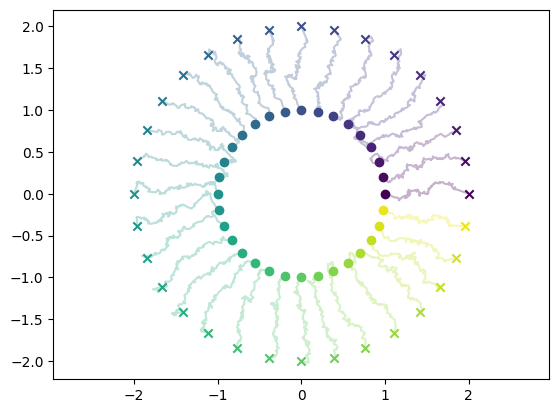

In [53]:
n = 1
with jax.default_device(jax.devices('cpu')[0]):
    for i in jnp.arange(num_samples, step=8):
        plt.scatter(ss[n, 0, 0, i], ss[n, 0, 1, i], marker='o', color=colors[i])
        plt.plot(ss[n, :, 0, i], ss[n, :, 1, i], alpha=0.3, color=colors[i])
        plt.scatter(ss[n, -1, 0, i], ss[n, -1, 1, i], marker='x', color=colors[i])
    plt.axis('equal')

### FFT test

signal shape:  (100,)
signal (rfft) shape:  (10,)
signal (reconstructed) shape:  (200,)


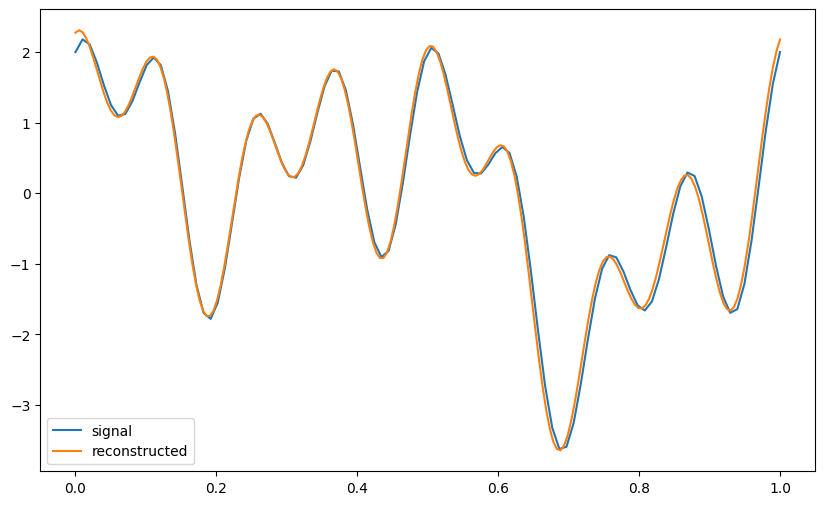

In [137]:
def f(t):
    return jnp.sin(2 * jnp.pi * t) + jnp.cos(4 * jnp.pi * t) + jnp.sin(8 * jnp.pi * t) + jnp.cos(16 * jnp.pi * t)

with jax.default_device(jax.devices('cpu')[0]):
    t = jnp.linspace(0, 1.0, 100)
    signal = f(t)
    print("signal shape: ", signal.shape)
    signal_freq = jnp.fft.rfft(signal, n=100)[:10]
    print("signal (rfft) shape: ", signal_freq.shape)
    signal_recon = jnp.fft.irfft(signal_freq*2, n=200) 
    print("signal (reconstructed) shape: ", signal_recon.shape)
    t_recon = jnp.linspace(0, 1.0, 200)
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, label='signal')
    plt.plot(t_recon, signal_recon, label='reconstructed')
    plt.legend()

#### Real and imaginary part

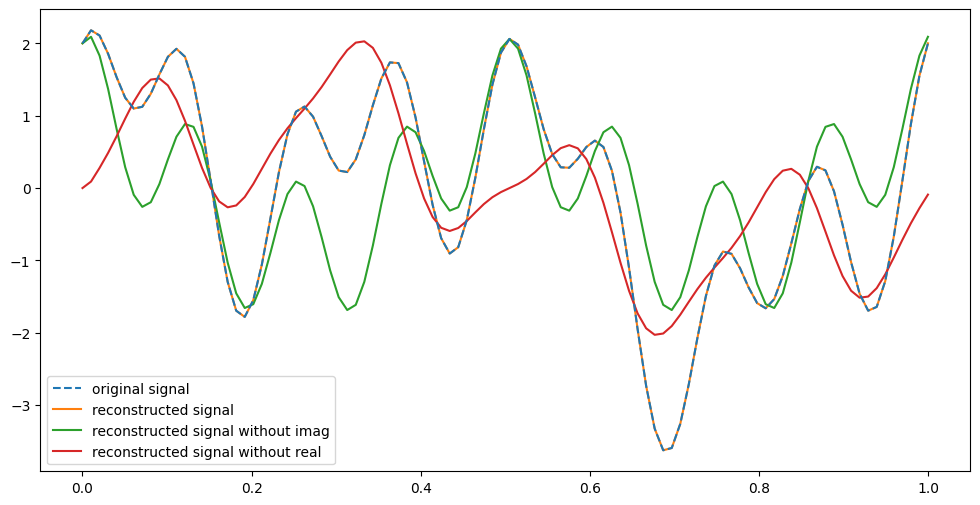

In [25]:
signal_freq_without_imag = signal_freq.real + 1j * jnp.zeros_like(signal_freq.real)
signal_freq_without_real = jnp.zeros_like(signal_freq.imag) + 1j * signal_freq.imag

signal_recon_without_imag = jnp.fft.irfft(signal_freq_without_imag, norm='backward')
signal_recon_without_real = jnp.fft.irfft(signal_freq_without_real, norm='backward')

plt.figure(figsize=(12, 6))
plt.plot(t, signal, label='original signal', linestyle='--', zorder=2)
plt.plot(t, signal_recon, label='reconstructed signal', zorder=1)
plt.plot(t, signal_recon_without_imag, label='reconstructed signal without imag', zorder=1)
plt.plot(t, signal_recon_without_real, label='reconstructed signal without real', zorder=1)
plt.legend()

#### Scaling

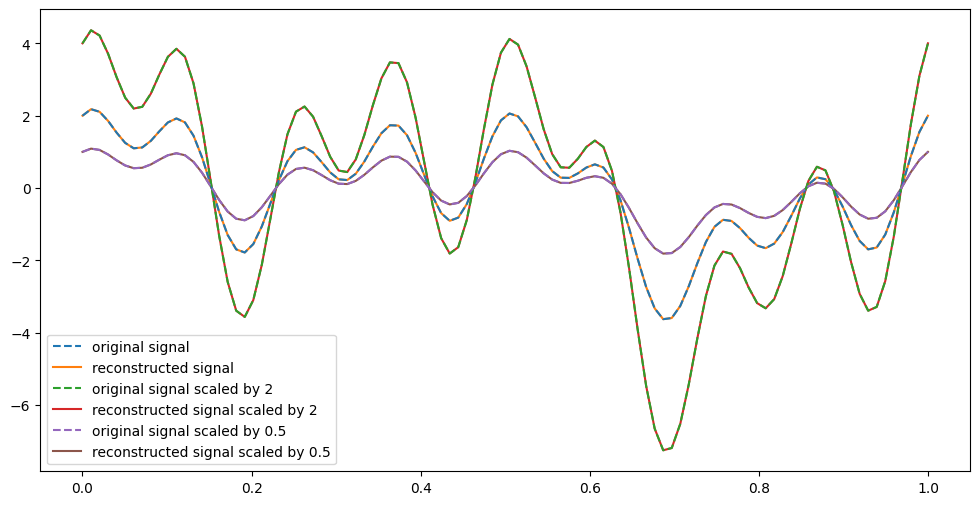

In [24]:
signal_freq_scaled_by_two = signal_freq * 2
signal_freq_scaled_by_half = signal_freq * 0.5

signal_recon_scaled_by_two = jnp.fft.irfft(signal_freq_scaled_by_two, norm='backward')
signal_recon_scaled_by_half = jnp.fft.irfft(signal_freq_scaled_by_half, norm='backward')

plt.figure(figsize=(12, 6))
plt.plot(t, signal, label='original signal', linestyle='--', zorder=2)
plt.plot(t, signal_recon, label='reconstructed signal', zorder=1)
plt.plot(t, signal*2, label='original signal scaled by 2', linestyle='--', zorder=2)
plt.plot(t, signal_recon_scaled_by_two, label='reconstructed signal scaled by 2', zorder=1)
plt.plot(t, signal*0.5, label='original signal scaled by 0.5', linestyle='--', zorder=2)
plt.plot(t, signal_recon_scaled_by_half, label='reconstructed signal scaled by 0.5', zorder=1)
plt.legend()